# Convolutional Networks
This script demos using spatial convolutional neural networks to build a supervised classifier for the crop labels using the input temporal images as features and also compares them against other classifiers.

In [ ]:
! pip install tqdm
! conda install -c conda-forge rtree --yes

In [16]:
from pylab import *

from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, concatenate, Input, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend 
import numpy as np
import common, preprocess
import tqdm, rtree

Because training a conv net can be computationally expensive, we're going to start with the previously selected features.

In [2]:
labels = common.loadNumpy('labels')
keyBands = preprocess.getKeyFeatures()

100%|██████████| 10/10 [01:38<00:00,  9.80s/it]


## Sampling considerations
Before we can build our conv net we need to appropriately sample the data.  Because we are using spatial conv nets, and not 1D conv nets over the temporal axis, we need to take into account the significant amount of spatial auto correlation in the data.  A naive random sampling approach, will show that the train/test scores are almost the same, because essentially there will be no truly held out data, because some of the training data is virtually guaranteed to come from every part of the image.  

To correctly hold out some data, we need to divide the image into either strips or chunks that represent groups that are held out. This allows us to most closely emulate the process of training a model on some subset of spatial data and then applying it to a completely unseen area. I choose to hold out large rectangular tiles from the image.  In each case, all of the tiles are entirely self-contained, no data leakage from nearby tiles is allowed.

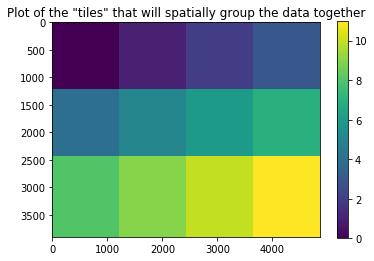

In [3]:
h,w = labels.shape
groups = np.zeros((h,w),dtype='uint8')
groupSize = max(h//4,w//4)
group = 0
groupRTree = rtree.index.Index()
groupMap = {}
for i in range(0, h, groupSize):
    for j in range(0,w,groupSize):
        
        si,ei = i, i+groupSize
        sj, ej = j, j+groupSize
        
        if ei > h:
            continue
        if ej > w: 
            continue
        
        if (i+2*groupSize) > h:
            ei = h
        if (j+2*groupSize) > w:
            ej = w
        
        groups[si:ei,sj:ej] = group
        groupRTree.insert(group,(sj,si,ej,ei))
        groupMap[group] = (si,ei,sj,ej)
#         print(i,j,group)
        group+=1

figure()
title('Plot of the "tiles" that will spatially group the data together')
imshow(groups)
colorbar()

In the above image, there are 12 groups.  For our tests, we will hold out all of the data from one or more tiles at once, and use the remaining tiles to train the model.  Because selecting which tiles to hold out is a potential source of bias, we will train in a cross-validation mode where we repeatedly train models on different subsets of the data by changing which tiles we are holding out.  This will not allow us to say that we have a single model that performs best, but it will enable us to say in general this is how well we would expect a model trained this way to perform on totally unseen data, while removing the selection bias.

In [4]:
h,w = labels.shape
featureArray = np.zeros((h,w,len(keyBands)))
for k, key in enumerate(keyBands):
    featureArray[:,:,k] = keyBands[key]

there are n classes 10


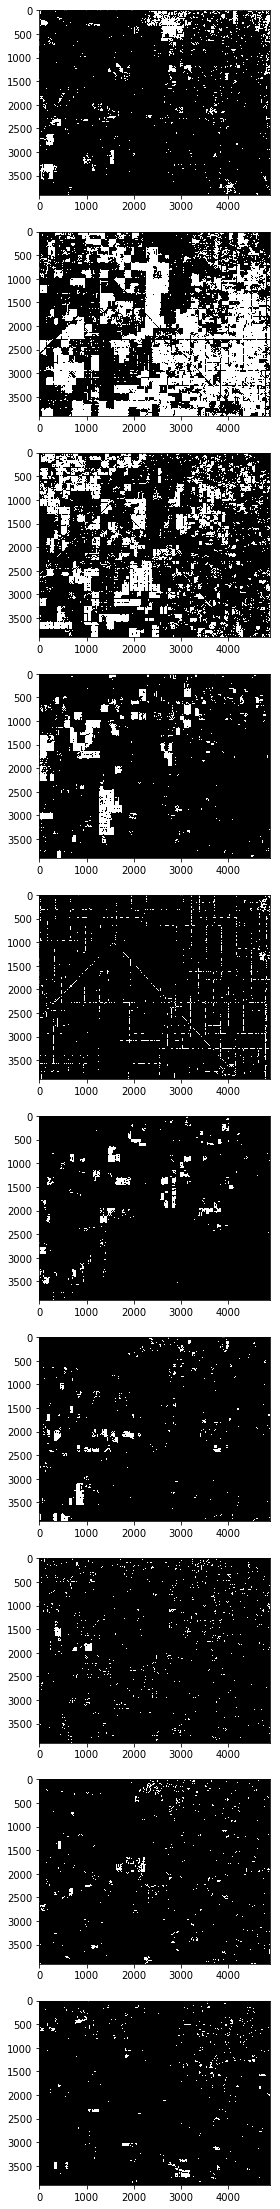

In [5]:
nclasses=int(labels.max())
print('there are n classes', nclasses)
# we need to use one hot labeling encoding for our labels
one_hot_labels = np.zeros((h,w,nclasses))

figure(figsize=(40,40))
for k in range(nclasses):
    mask = labels == k
    im_ones = np.zeros_like(labels)
    im_ones[mask] = 1
    one_hot_labels[:,:,k] = im_ones
    subplot(10,1,k+1)
    imshow(im_ones,cmap='gray',vmax=1.0)

In [6]:
featureArray.shape

(3902, 4873, 20)

Now we load the data, and format it for our convolutional neural network. Our conv net will take 3d tiles of size 64x64x20 where 64x64 is the spatial dimension, and 20 is the number of features. I chose 64x64 because it gives us enough context to say what is going on nearby without making it so large that it becomes problematic to train the model.  Because the tile shape does not evenly divide into the grouping shape, we have to be careful to ensure that we're not gathering data from outside of our group.

In [7]:
tileHeight = 64
tileWidth = 64
tiles = []
ytiles = []
tileGroups = []
tileInfo = {}

tileIndex = 0
for ty in range(0, h, tileHeight):
    for tx in range(0, w, tileWidth):
        sy = ty
        sx = tx
        ey = sy+tileHeight
        ex = sx+tileWidth
        groups = list(groupRTree.intersection((sx,sy,ex,ey)))
        # if we span more than one group, then we need to make two tiles
        # one for each group, but that is limited to each groups visible data
        # this prevents data leakage from one group to the next .
        for group in groups:
            gsy,gey, gsx,gex = groupMap[group]
            if ey > gey:
                sy = gey-tileHeight
                ey = gey
            elif sy < gsy:
                sy = gsy
                ey = gsy + tileHeight
                
            if ex > gex:
                sx = gex-tileWidth
                ex = gex
            elif sx < gsx:
                sx = gsx
                ex = gsx+tileWidth
                
            assert ex-sx == tileWidth
            assert ey-sy == tileHeight
            tileInfo[tileIndex] = (sy,ey,sx,ex, group)

            tiles.append(featureArray[sy:ey,sx:ex])
            ytiles.append(one_hot_labels[sy:ey,sx:ex])
            tileGroups.append(group)

            tileIndex+=1
        

In [8]:
tileArray = np.array(tiles)
yTileArray = np.array(ytiles)
groupArray = np.array(tileGroups)
del tiles
del ytiles


In [9]:
tileArray.shape, yTileArray.shape, groupArray.shape

((5040, 64, 64, 20), (5040, 64, 64, 10), (5040,))

In [10]:
from sklearn.model_selection import LeavePGroupsOut

Here's an example that shows how using the groups with the tiles will automatically break up the data for us.

In [11]:
lpo = LeavePGroupsOut(4)
print('n splits', lpo.get_n_splits(tileArray,yTileArray,groupArray))

n splits 495


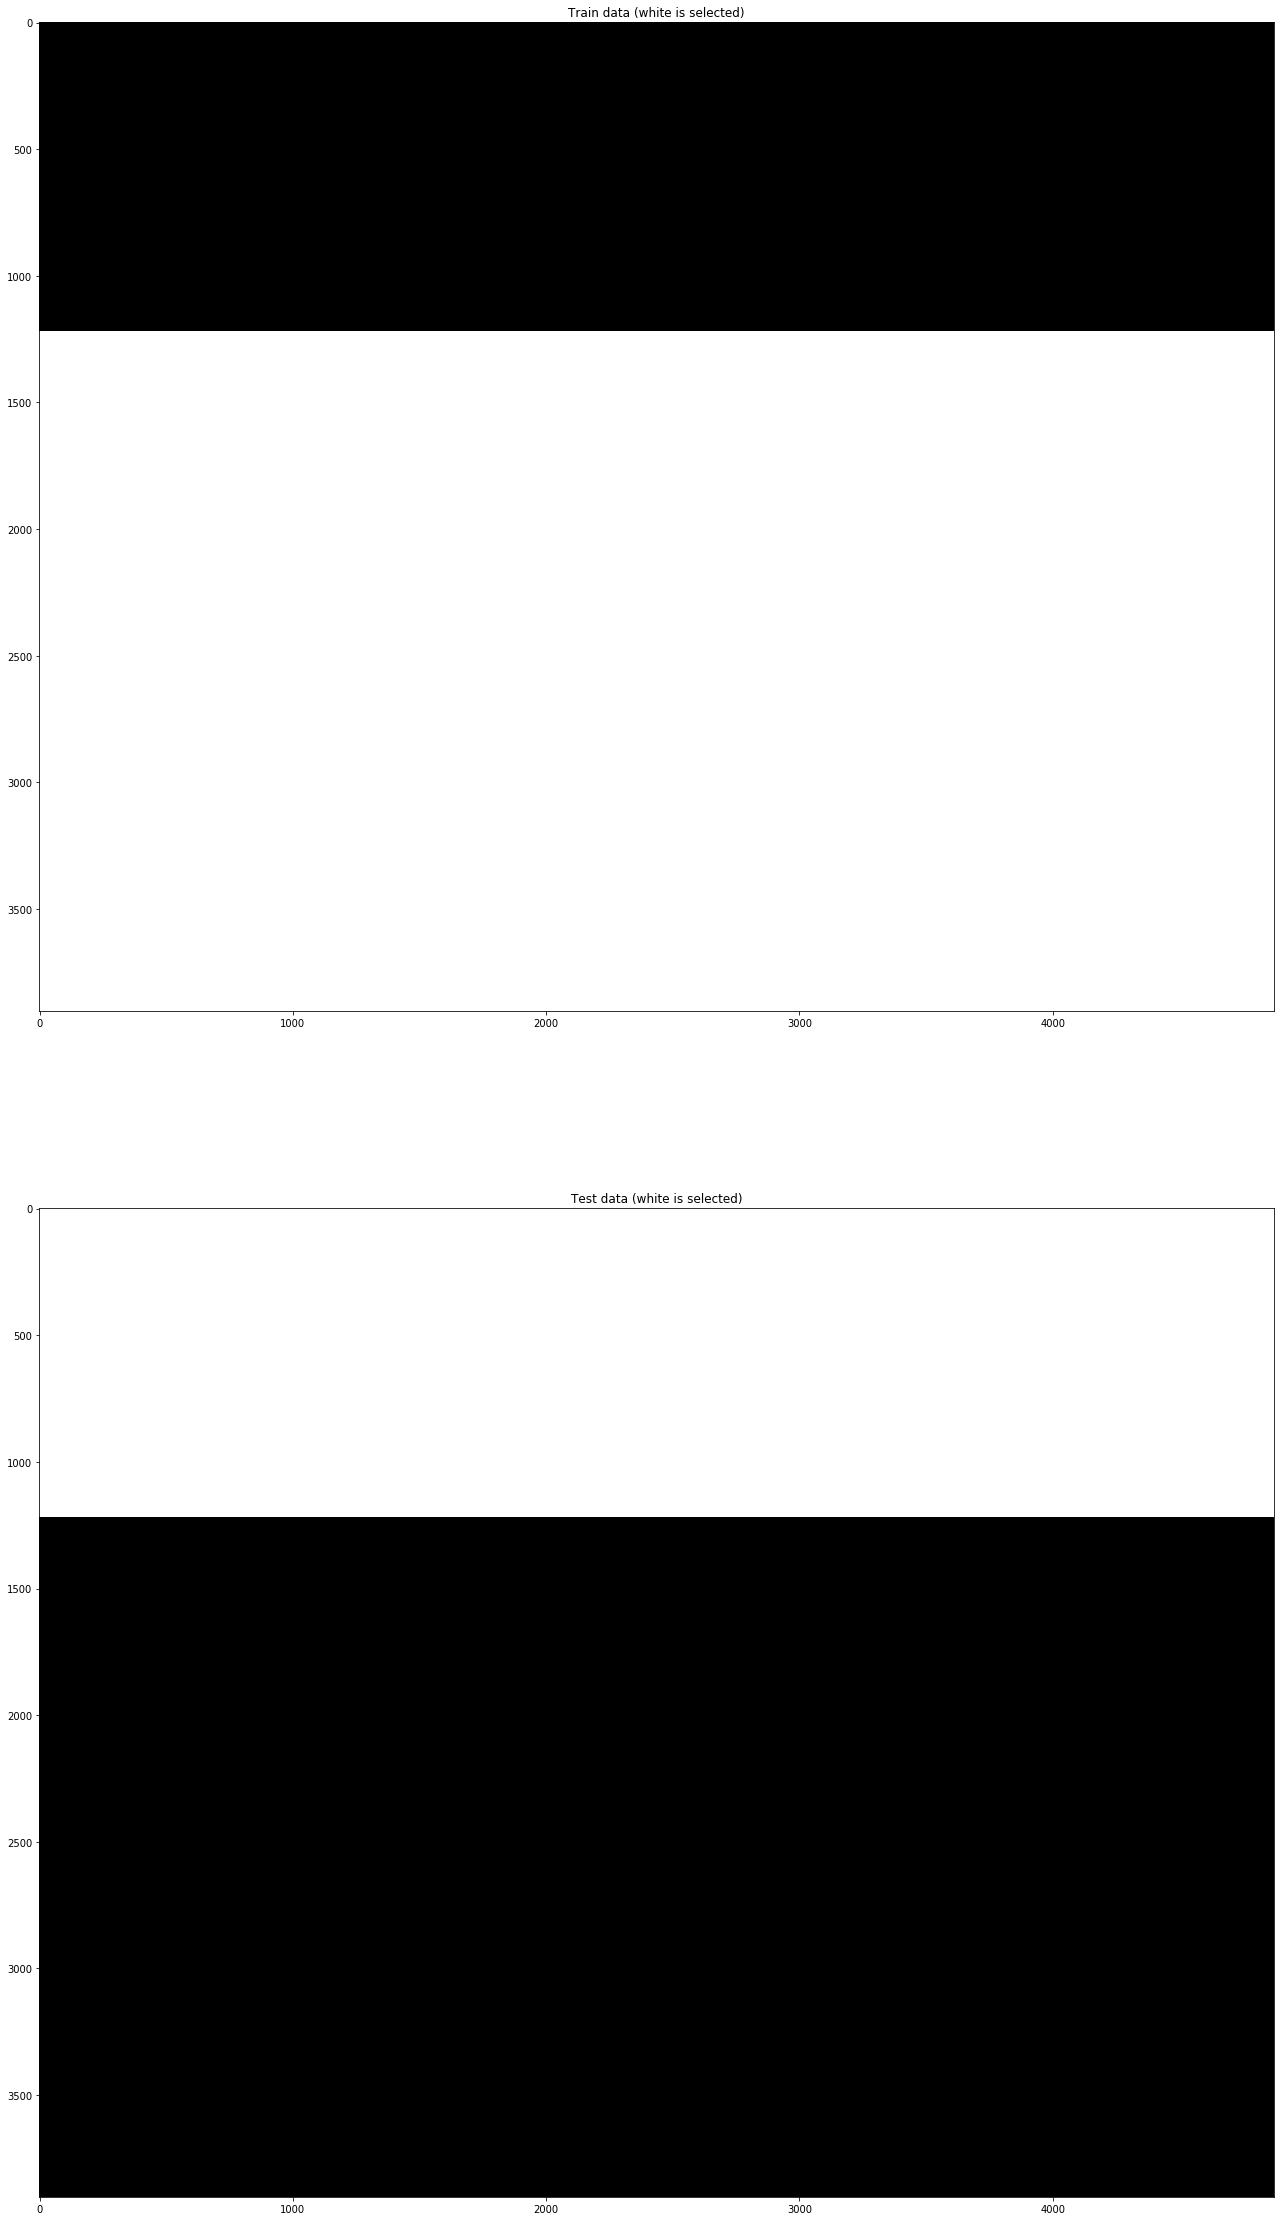

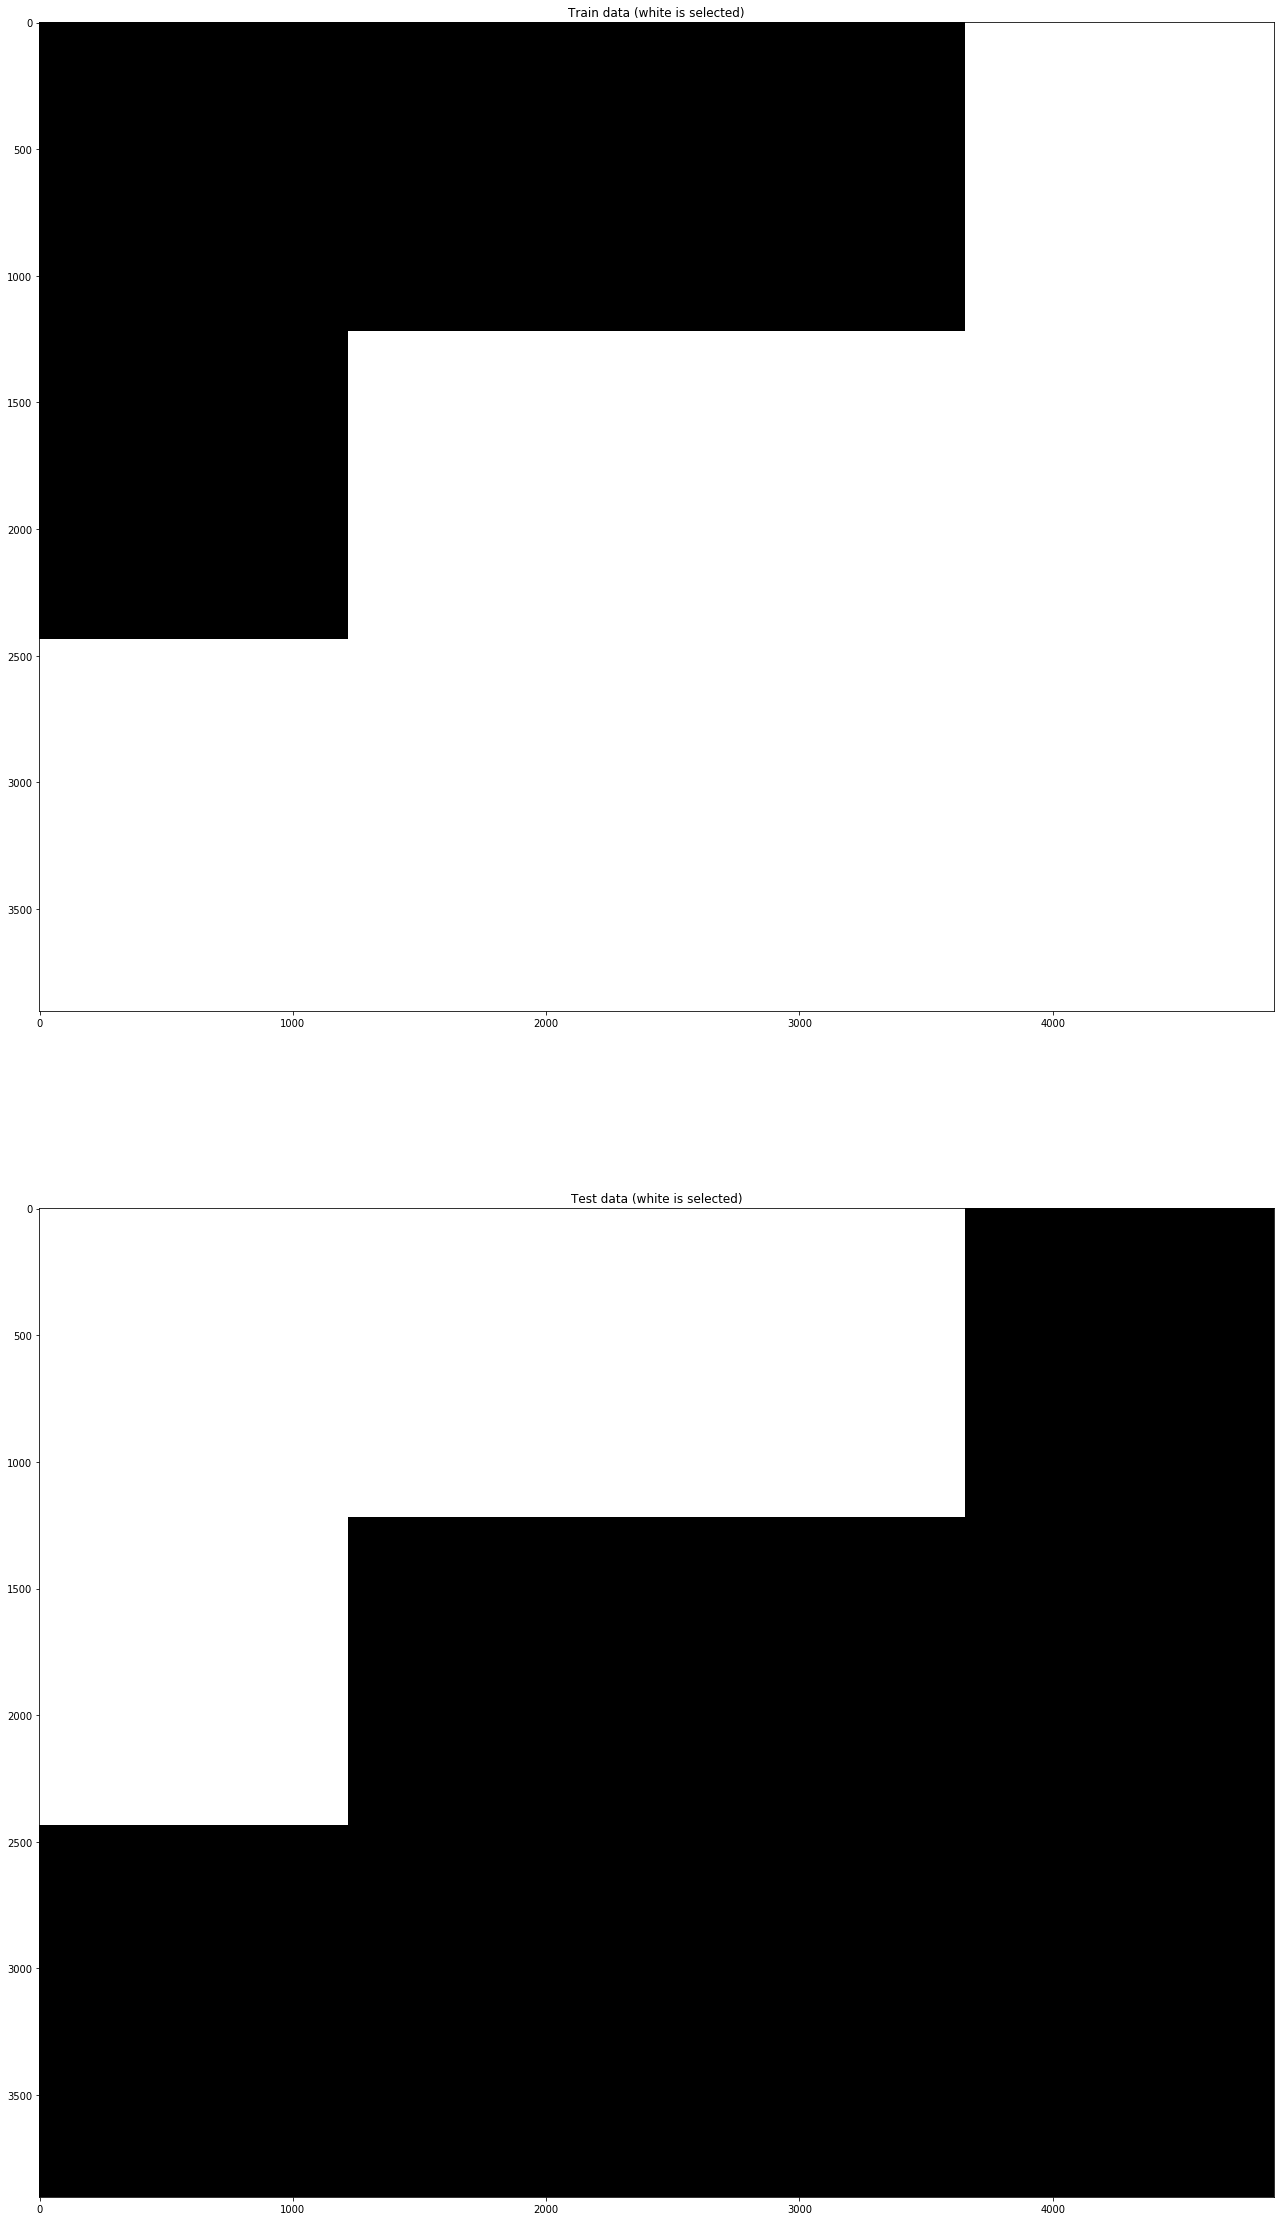

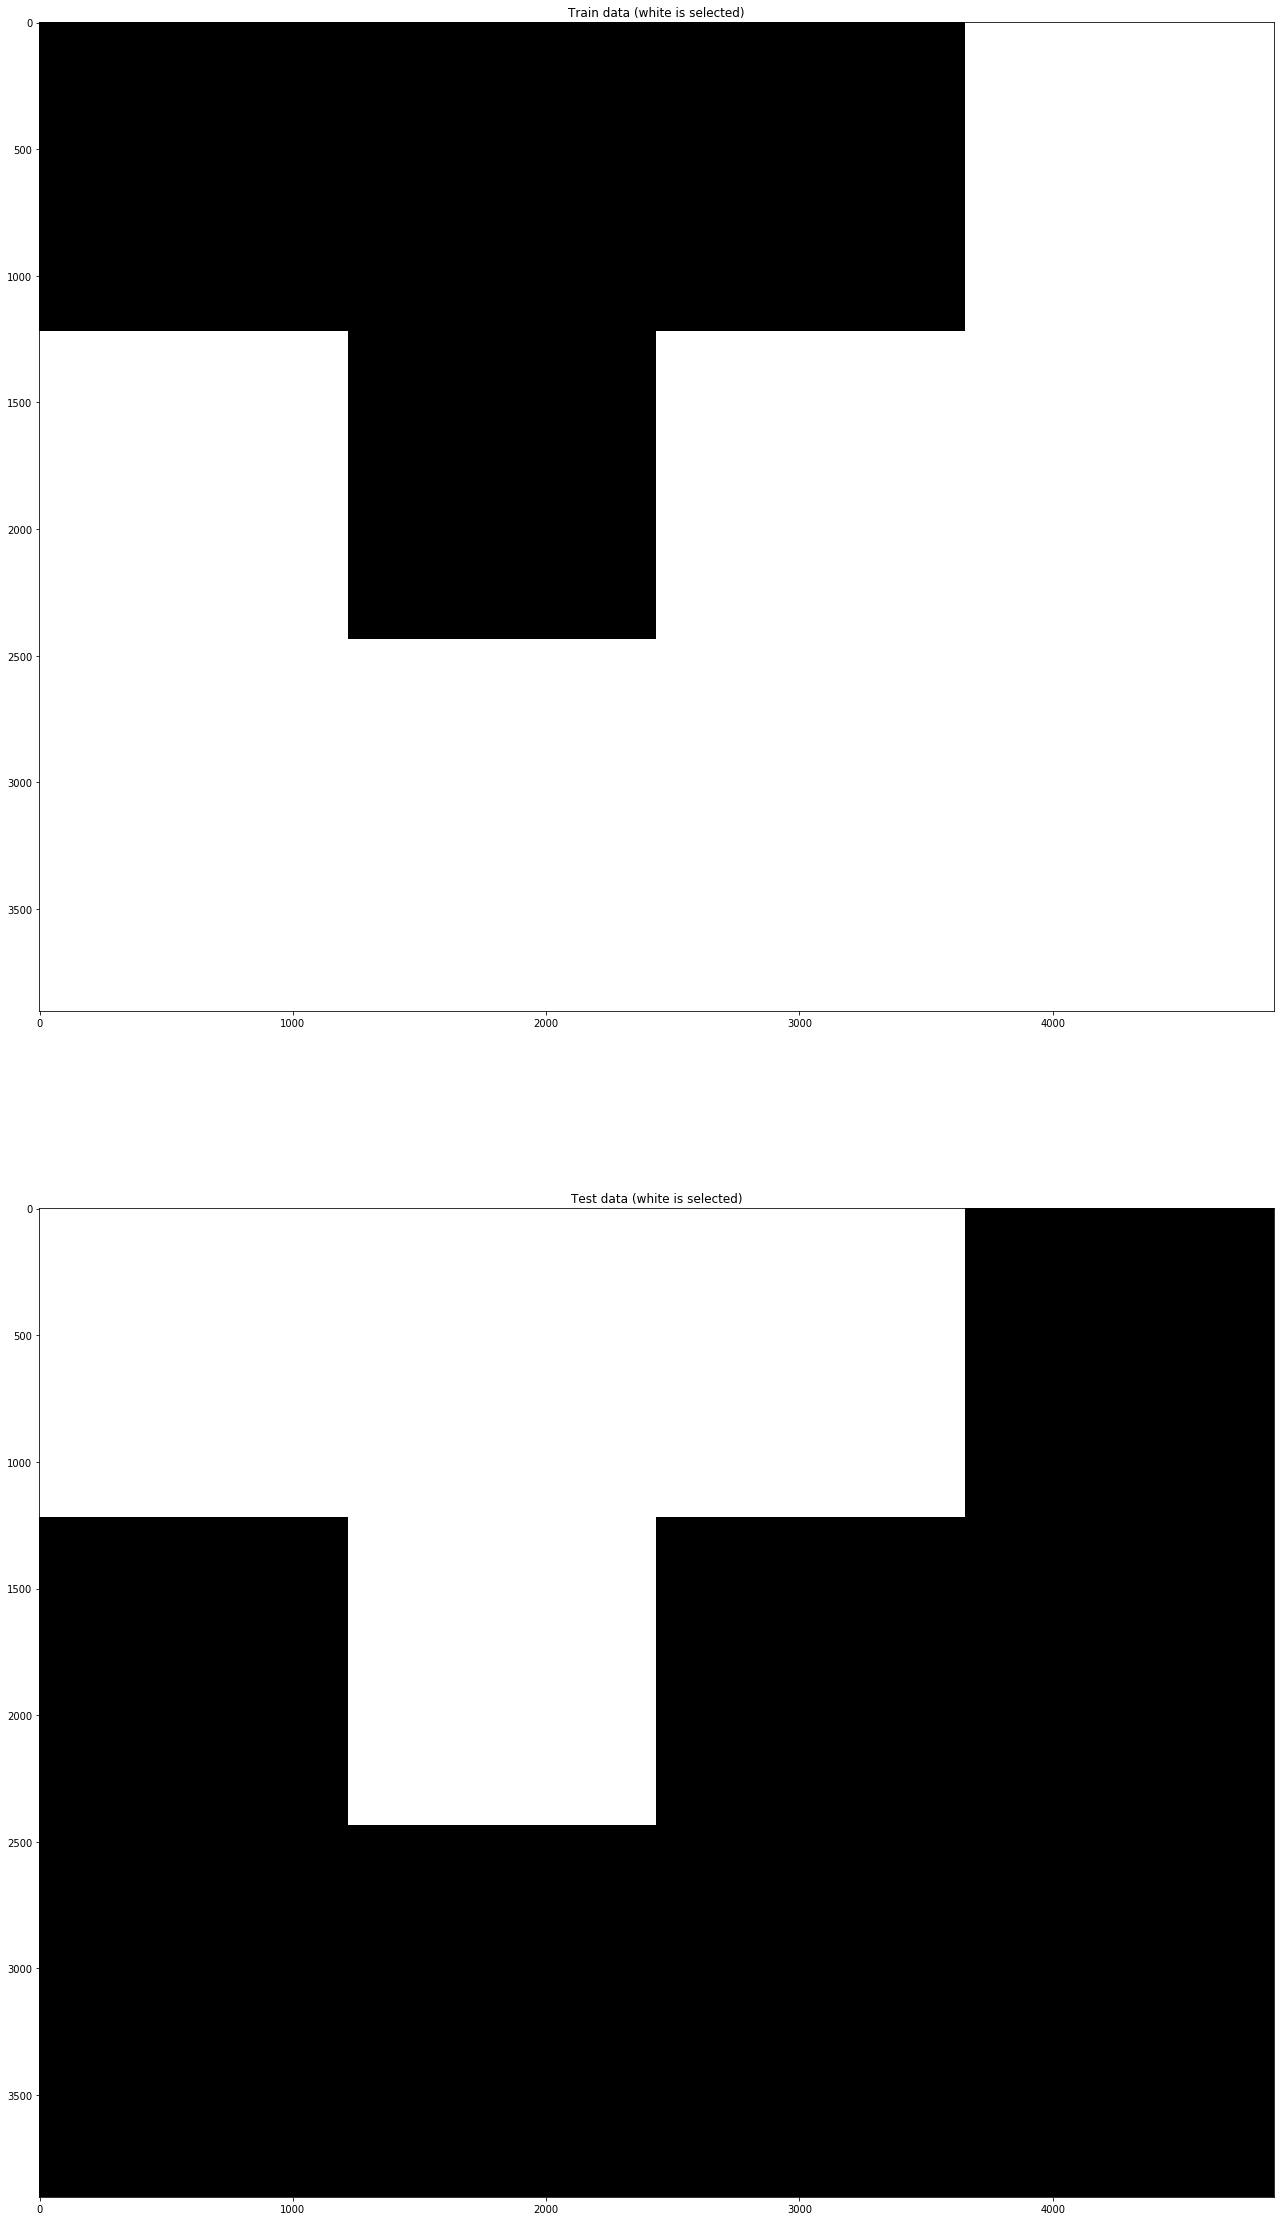

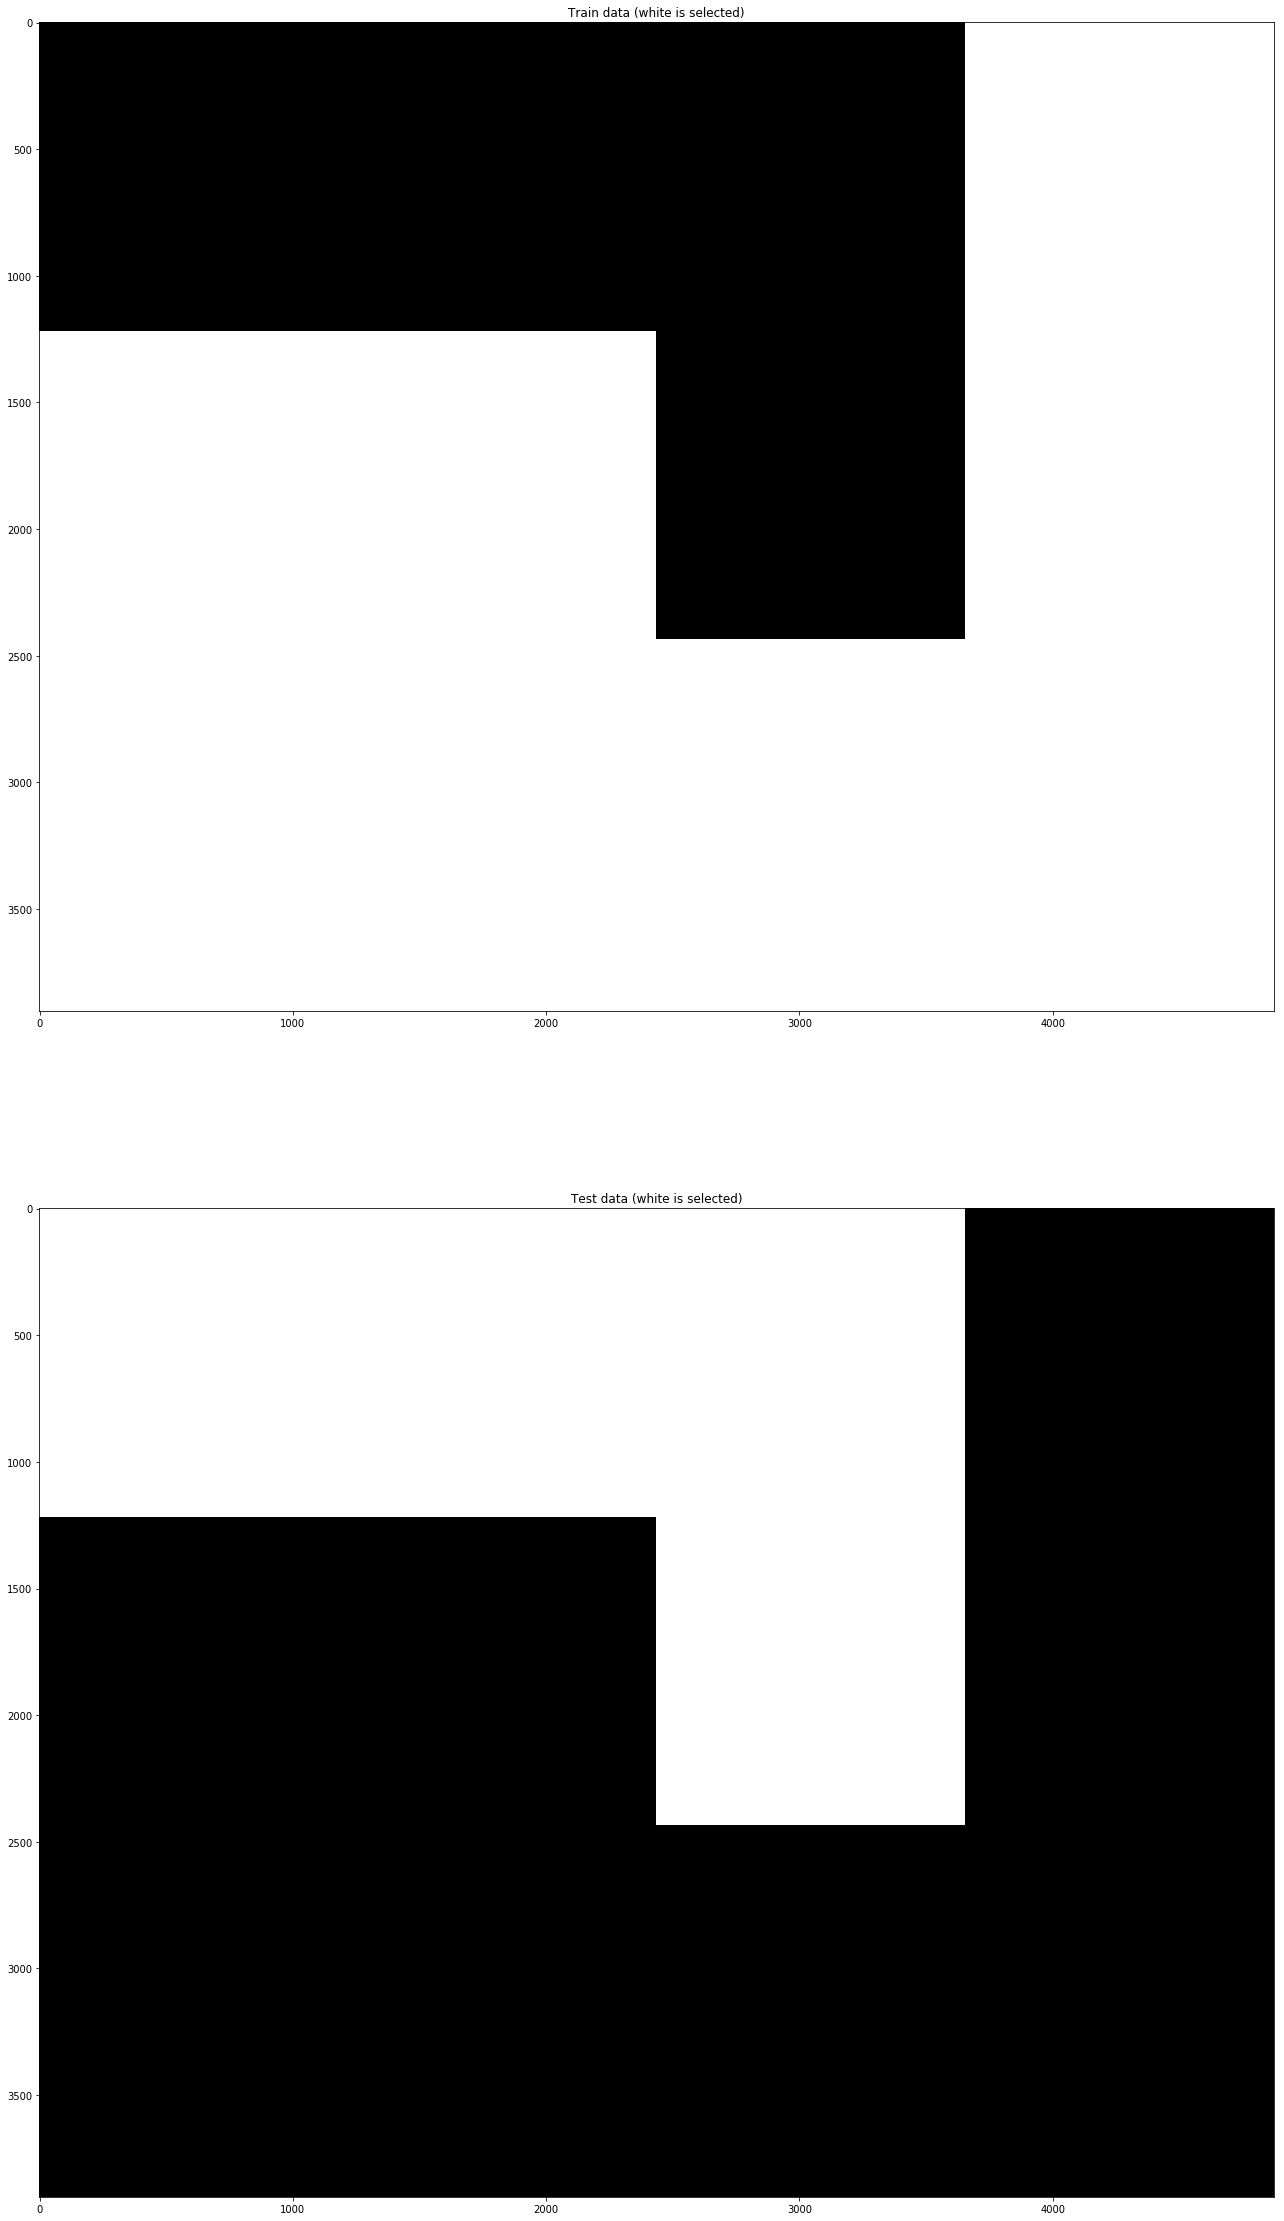

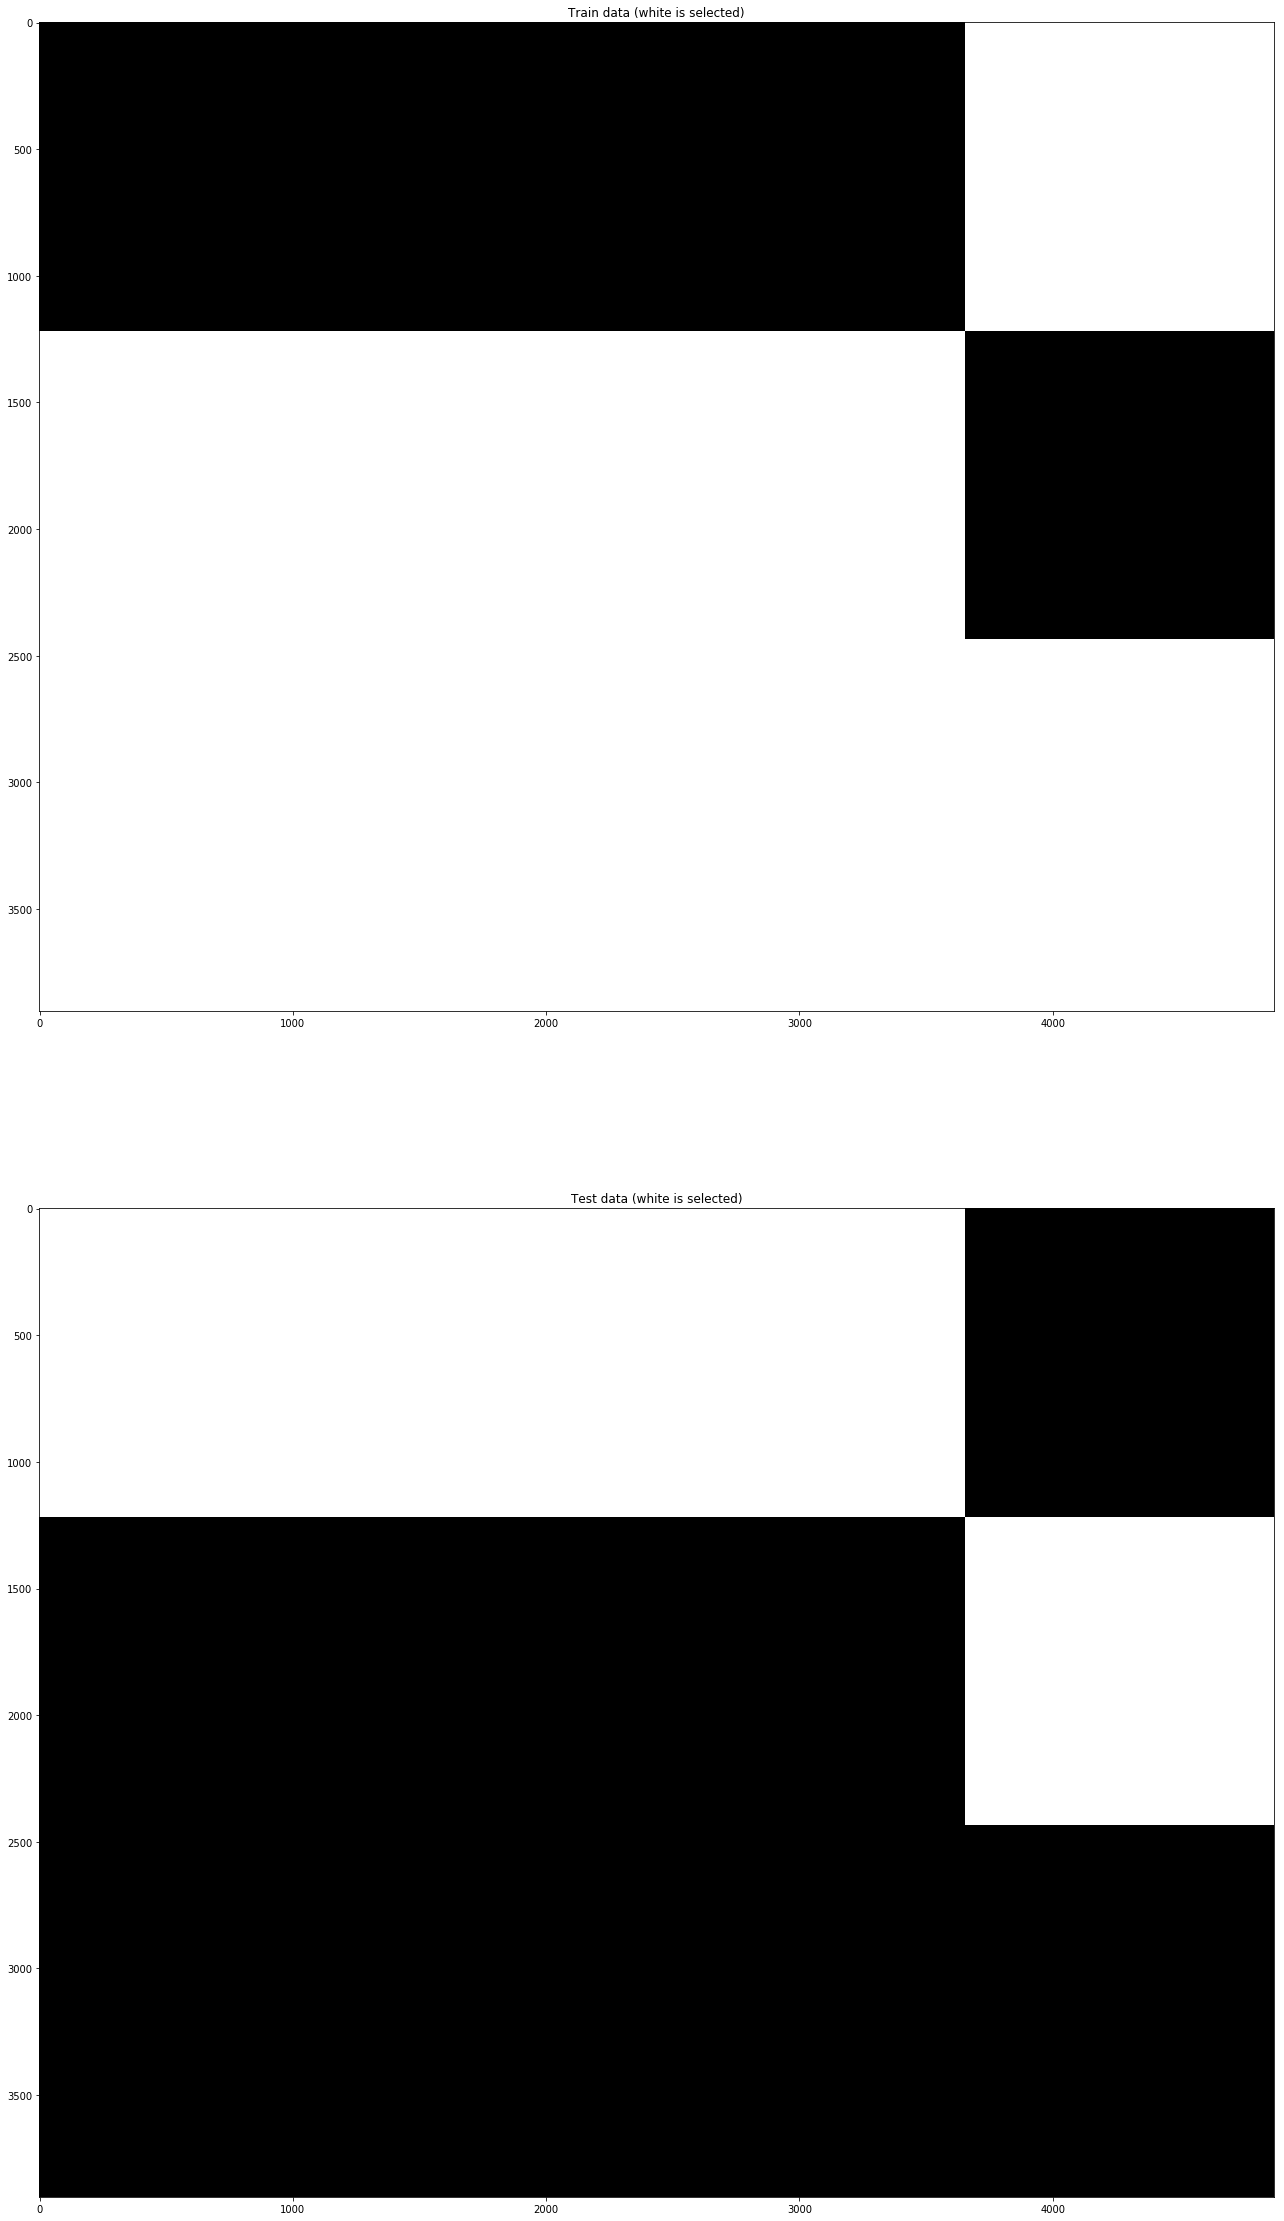

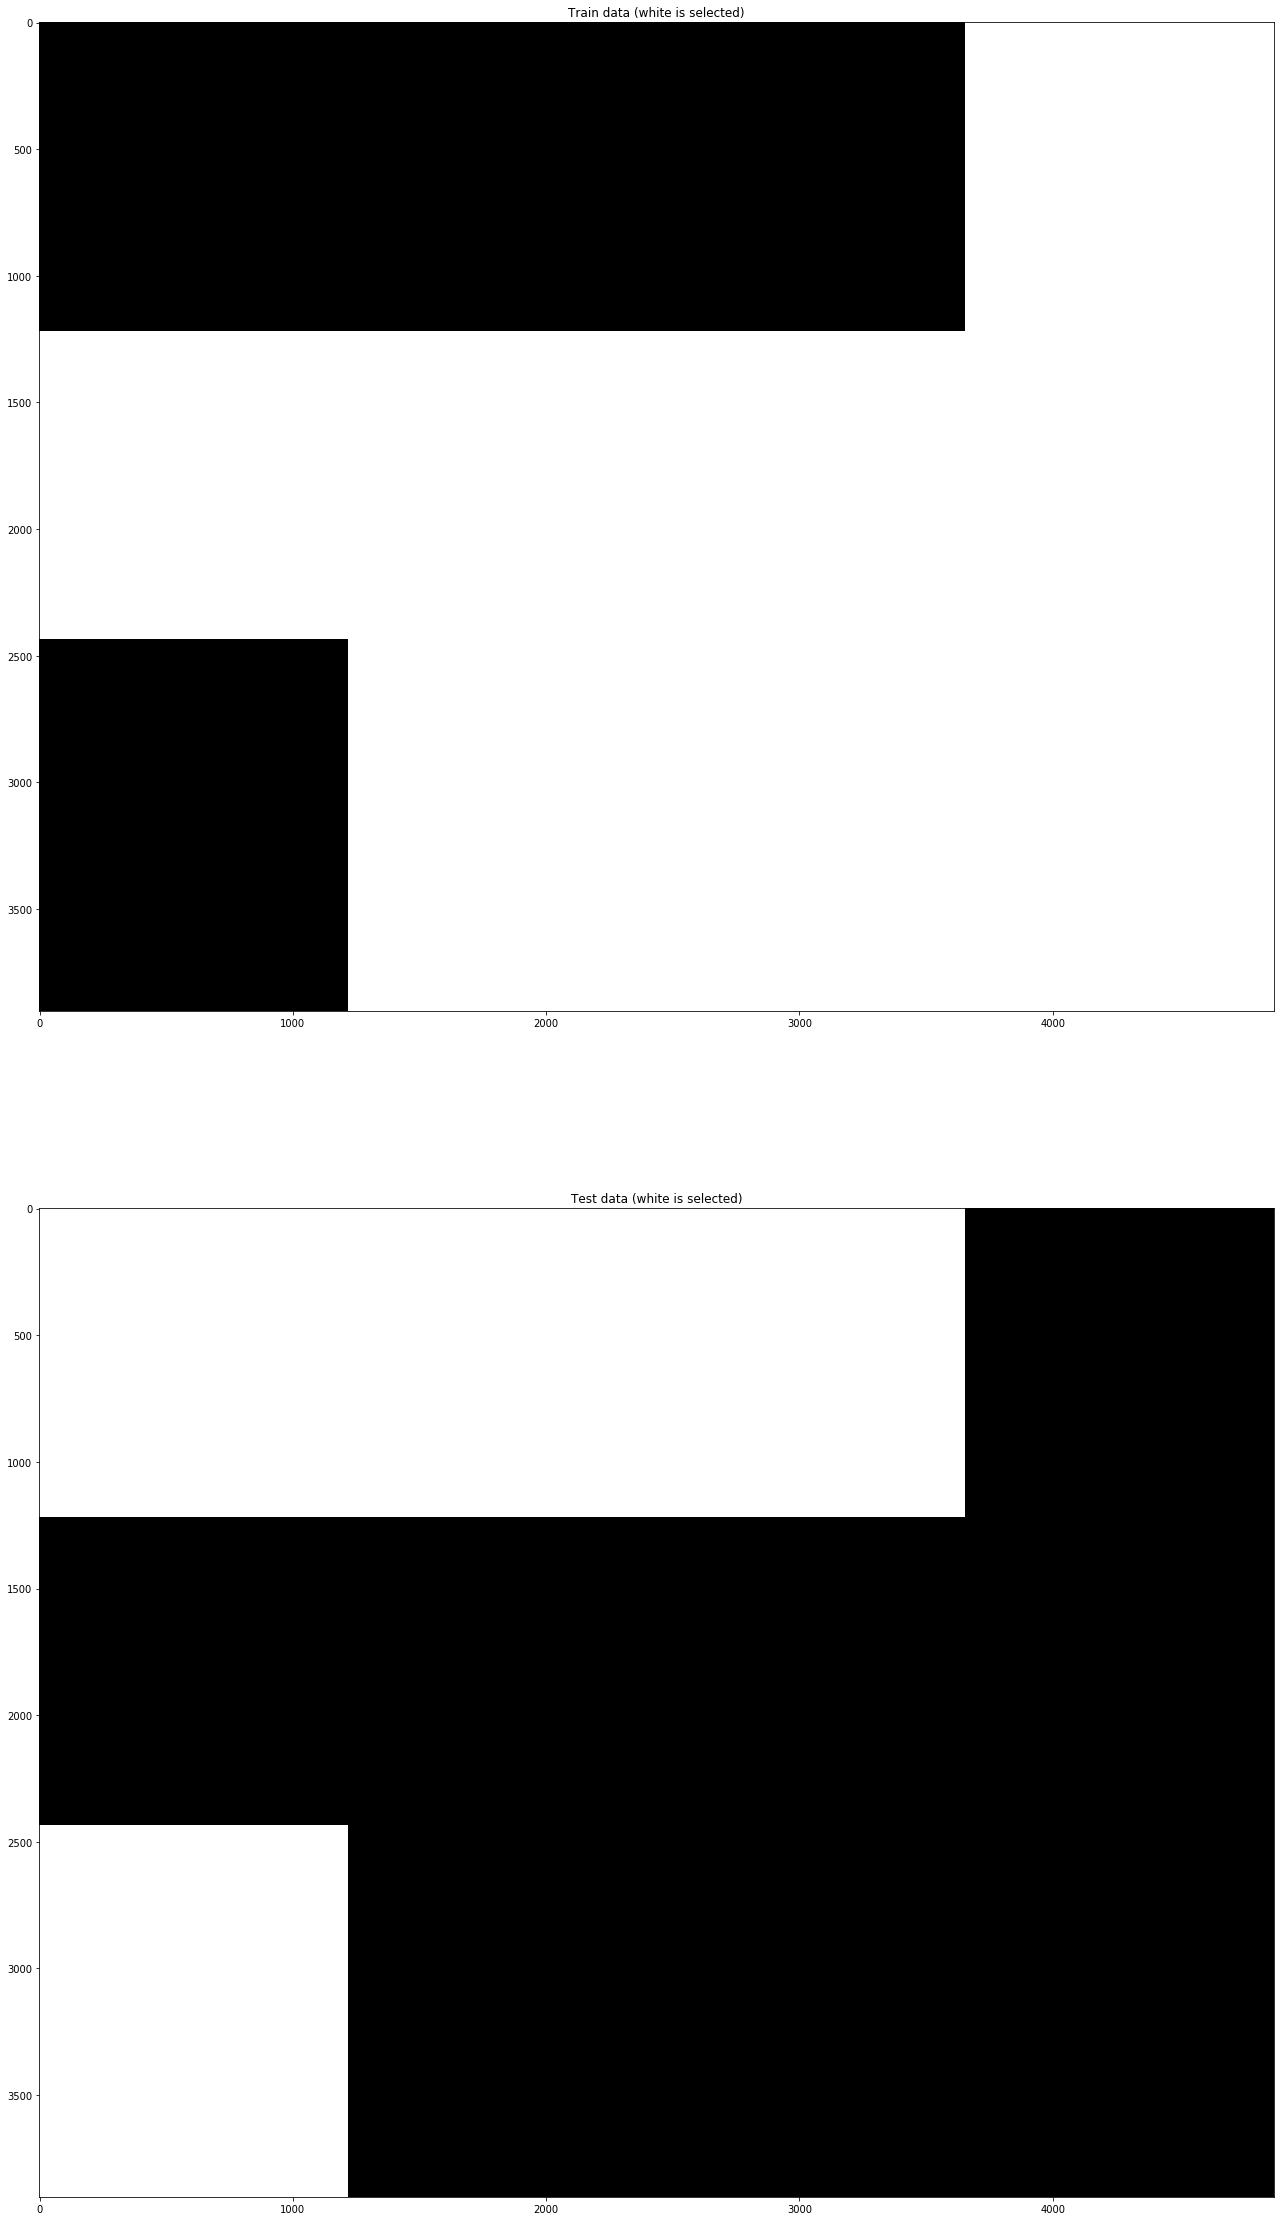

In [12]:
k = 0
for train_index, test_index in lpo.split(tileArray, yTileArray,groupArray):
#     print('train_index', train_index)
#     print('test_index', test_index)
    if k > 5: 
        break
        
    figure(figsize=(40,40))
    subplot(211)
    title('Train data (white is selected)')
    trainImg = zeros_like(labels)
    for idx in train_index:
        sy,ey,sx,ex, g = tileInfo[idx]
        trainImg[sy:ey,sx:ex] = 1
    imshow(trainImg,cmap='gray',vmax=1)
    subplot(212)
    title('Test data (white is selected)')
    testImg = zeros_like(labels)
    for idx in test_index:
        sy,ey,sx,ex, g = tileInfo[idx]
        testImg[sy:ey,sx:ex] = 1
    imshow(testImg,cmap='gray',vmax=1)
    k+=1

Now it's time to train our model.  For our convolutional neural network we're going to use a vanilla U-net and treat this as a semantic segmentation problem.

In [17]:
def model(trainTiles, yTiles):
    backend.clear_session()
    nb,h,w,c = trainTiles.shape
    nby,hy,wy,cy = yTiles.shape
    assert nb == nby
    assert h == hy
    assert w == wy
    
    i1 = Input((h,w,c))
    # 64x64
    c1 = Conv2D(32,3,padding='same',activation='relu')(i1)
    c1 = Conv2D(32,3,padding='same',activation='relu')(c1)
    p1 = MaxPooling2D()(c1)
    b1 = BatchNormalization()(p1)
    # 32x32
    c2 = Conv2D(64,3,padding='same',activation='relu')(b1)
    c2 = Conv2D(64,3,padding='same',activation='relu')(c2)
    p2 = MaxPooling2D()(c2)
    b2 = BatchNormalization()(p2)
    
    # 16x16
    c3 = Conv2D(128,3,padding='same',activation='relu')(b2)
    c3 = Conv2D(128,3,padding='same',activation='relu')(c3)
    p3 = MaxPooling2D()(c3)
    b3 = BatchNormalization()(p3)
    
    # 8x8
    c4 = Conv2D(256,3,padding='same',activation='relu')(b3)
    c4 = Conv2D(256,3,padding='same',activation='relu')(c4)
    p4 = MaxPooling2D()(c4)
    b4 = BatchNormalization()(p4)

    # 4x4
    c5 = Conv2D(512,3,padding='same',activation='relu')(b4)
    c5 = Conv2D(512,3,padding='same',activation='relu')(c5)
    
    # 8x8
    u4 = UpSampling2D()(c5)
    u4 = concatenate([c4,u4],axis=3)
    u4 = Conv2D(256,3,padding='same',activation='relu')(u4)
    u4 = Conv2D(256,3,padding='same',activation='relu')(u4)
    u4 = BatchNormalization()(u4)
    
    #16x16
    u3 = UpSampling2D()(u4)
    u3 = concatenate([c3,u3],axis=3)
    u3 = Conv2D(128,3,padding='same',activation='relu')(u3)
    u3 = Conv2D(128,3,padding='same',activation='relu')(u3)
    u3 = BatchNormalization()(u3)
    
    #32x32
    u2 = UpSampling2D()(u3)
    u2 = concatenate([c2,u2],axis=3)
    u2 = Conv2D(64,3,padding='same',activation='relu')(u2)
    u2 = Conv2D(64,3,padding='same',activation='relu')(u2)
    u2 = BatchNormalization()(u2)
    
    #64x64
    u1 = UpSampling2D()(u2)
    u1 = concatenate([c1,u1],axis=3)
    u1 = Conv2D(32,3,padding='same',activation='relu')(u1)
    u1 = Conv2D(32,3,padding='same',activation='relu')(u1)
    u1 = BatchNormalization()(u1)
    
    o1 = Conv2D(16, 3, padding='same',activation='relu')(u1)
    o1 = Conv2D(cy, 1, padding='same',activation='softmax')(o1)
    
    return Model(input=[i1], outputs=[o1])




In [23]:
def augmentData(x,y):
    ox = []
    oy = []
    ox.append(x)
    oy.append(y)
    #flip ud
    ox.append(x[:,::-1,:,:])
    oy.append(y[:,::-1,:,:])
    #flip lr
    ox.append(x[:,:,::-1,:])
    oy.append(y[:,:,::-1,:])
    #flip ud-lr
    ox.append(x[:,::-1,::-1,:])
    oy.append(y[:,::-1,::-1,:])
    print(len(ox), len(oy), x.shape)
    return np.concatenate(ox,axis=0), np.concatenate(oy,axis=0)

The summary of the model below shows the model schema.

In [19]:
m = model(tileArray, yTileArray)    

m.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 20)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   5792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_norm

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


To start we're going to use the naive random sampling approach and show what happens
with training and test validation. 

In [27]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(tileArray,yTileArray,train_size=0.5)

In [28]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((2520, 64, 64, 20),
 (2520, 64, 64, 20),
 (2520, 64, 64, 10),
 (2520, 64, 64, 10))

Do some basic augmentation here to help out a bit.

In [29]:
xa, ya = augmentData(xtrain,ytrain)

4 4 (2520, 64, 64, 20)


In [30]:
xa.shape, ya.shape

((10080, 64, 64, 20), (10080, 64, 64, 10))

In [31]:
# these are just some basic choices, with more time we could investigate more options
m.compile(Adam(lr=1e-4),metrics=['accuracy'],loss='categorical_crossentropy')

In [32]:
m.fit(xa,ya,validation_split=0.1,batch_size=128,epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 9072 samples, validate on 1008 samples
Epoch 1/10
9072/9072 [==============================] - 49s 5ms/step - loss: 1.4426 - acc: 0.5517 - val_loss: 1.1605 - val_acc: 0.6499
Epoch 2/10
9072/9072 [==============================] - 35s 4ms/step - loss: 1.0308 - acc: 0.6771 - val_loss: 0.9500 - val_acc: 0.6948
Epoch 3/10
9072/9072 [==============================] - 34s 4ms/step - loss: 0.9071 - acc: 0.7140 - val_loss: 0.8905 - val_acc: 0.7125
Epoch 4/10
9072/9072 [==============================] - 34s 4ms/step - loss: 0.8329 - acc: 0.7331 - val_loss: 0.8223 - val_acc: 0.7284
Epoch 5/10
9072/9072 [==============================] - 34s 4ms/step - loss: 0.7808 - acc: 0.7445 - val_loss: 0.7955 - val_acc: 0.7366
Epoch 6/10
9072/9072 [==============================] - 35s 4ms/step - loss: 0.7268 - acc: 0.7600 - val_loss: 0.7481 - val_acc: 0.7489
Epoch 7/10
9072/9072 [========================

Normally, we'd let this run for a longer time and use early stopping to prevent overfitting, but since we don't want to consume a lot of resources right now we'll let it stop after 10 epochs, even at the risk of underfitting.

In [33]:
predictions = m.predict(tileArray)
results = np.zeros_like(labels)
for k, predictionTile in enumerate(predictions):
    sy,ey,sx,ex,g = tileInfo[k]
    results[sy:ey,sx:ex] = np.argmax(predictionTile,axis=2)

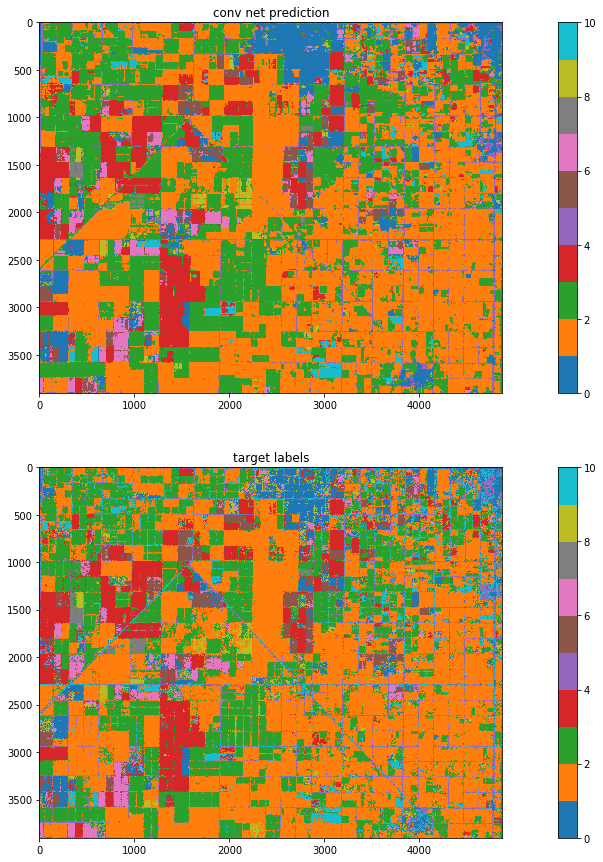

In [37]:
figure(figsize=(20,15))

subplot(211)
title('conv net prediction')
imshow(results,cmap='tab10',vmax=10)
colorbar()
subplot(212)
title('target labels')
imshow(labels,cmap='tab10',vmax=10)
colorbar()
savefig('raw_conv.png')

We split the data into 50/50 train and validation split, and we get a pretty decent result, but we can clearly see that the biggest difference between the two images is that it looks like the predicted image is smoothed relative to the right image.  However, it has made some of the predicted labels more contiguous relative to what we see in the raw labels, and picked out some areas that look more reasonable to me that what we see in the raw data.

In [38]:
import stats
print(stats.prf1_score_img(labels, results))

      Recall  Precision        F1  Support
0   0.546316   0.696750  0.612430  1141647
1   0.873430   0.871496  0.872462  8300189
2   0.739877   0.836237  0.785111  4721173
3   0.811523   0.831542  0.821411  1540735
4   0.379595   0.377573  0.378582   754481
5   0.787989   0.602592  0.682931   615181
6   0.536601   0.584193  0.559386   490124
7   0.604235   0.132797  0.217740   409151
8   0.461382   0.259696  0.332333   378777
9   0.563393   0.504238  0.532177   339901
10  0.000000   0.000000  0.000000   323087


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Unfortunately because there is so much noise in the target labels the P-R and F1 stats don't look very good, but I'm not super concerned about the inability to quantify how good the results are here.  Ultimately, I'd have to know more about how "good" the target labels are in order to say if we should be matching them better.

Comparing these results to those we obtained from the Random Forest Classifier in the Feature Selection section, we see that these results are actually pretty comparable, and in most cases better.  Keep in mind though, that the conv net has seen significantly more data points than the RFC, so if the RFC was given enough data it might do better.

In [39]:
del xa, ya, xtrain,xtest, ytrain, ytest

Now we run the true held out test, where we hold out entire groups of data from the model during the training phase, and then predict only on those groups. This should give us a much better idea of how well it will predict on new areas.

In [ ]:
nExamples = 0
kPermutation = 0
predictionImage = []

for train_index, test_index in lpo.split(tileArray, yTileArray,groupArray):
    kPermutation += 1
    
    if kPermutation % 10 != 0:
        continue
        
    if nExamples > 3:
        break
        
    xt = tileArray[train_index]
    yt = yTileArray[train_index]
    print(xt.shape,yt.shape)
    xa,ya = augmentData(xt,yt)
    print(xa.shape,ya.shape)
    temp_model = model(xa,ya)
    temp_model.compile(Adam(lr=1e-4),metrics=['accuracy'],loss='categorical_crossentropy')
    # normally I'd use early stopping but 10 epochs seems to be about right
    temp_model.fit(xa,ya,validation_split=0.1,batch_size=128,epochs=10)
    
    
    predictions = temp_model.predict(tileArray[test_index])
    results = np.zeros_like(labels)
    mask    = np.zeros(labels.shape,dtype='bool')

    del xa, ya, predictions
    
    prediction_groups = set()
    for k, predictionTile in enumerate(predictions):
        sy,ey,sx,ex,g = tileInfo[test_index[k]]
        prediction_groups.add(g)
        results[sy:ey,sx:ex] = np.argmax(predictionTile,axis=2)
        mask[sy:ey,sx:ex] = 1

    f = figure(figsize=(40,40))
    f.set_tight_layout(True)
    nrows = len(prediction_groups)
    for k, prediction_group in enumerate(prediction_groups):
        sy,ey, sx, ex = groupMap[prediction_group]
        subplot(nrows,2,2*k+1)
        imshow(results[sy:ey,sx:ex],cmap='tab10')
        ylabel('group: {0}'.format(prediction_group))
        subplot(nrows,2,2*k+2)
        imshow(labels[sy:ey,sx:ex],cmap='tab10')

    f.savefig('conv_heldout_example_{:02d}.png'.format(nExample))
    print('**** Summary stats for Example: {} ****'.format(nExample))
    print(stats.prf1_score_img(labels[mask],results[mask]))
    
    predictionImage.append(results)
    nExamples+=1
    

(3440, 64, 64, 20) (3440, 64, 64, 10)
4 4 (3440, 64, 64, 20)
(13760, 64, 64, 20) (13760, 64, 64, 10)


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


Train on 12384 samples, validate on 1376 samples
Epoch 1/10
12384/12384 [==============================] - 55s 4ms/step - loss: 1.5338 - acc: 0.5553 - val_loss: 1.0547 - val_acc: 0.7273
Epoch 2/10
12384/12384 [==============================] - 50s 4ms/step - loss: 1.0236 - acc: 0.7060 - val_loss: 0.8124 - val_acc: 0.7739
Epoch 3/10
12384/12384 [==============================] - 50s 4ms/step - loss: 0.8598 - acc: 0.7423 - val_loss: 0.7239 - val_acc: 0.7865
Epoch 4/10
12384/12384 [==============================] - 50s 4ms/step - loss: 0.7733 - acc: 0.7584 - val_loss: 0.6241 - val_acc: 0.8090
Epoch 5/10
  512/12384 [>.............................] - ETA: 46s - loss: 0.7318 - acc: 0.7635